In [2]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score

# ---------- Chemins (modifie si besoin) ----------
TRAIN_PATH = "Data/train.csv"         # chemin par défaut
TEST_PATH = "Data/test.csv"
SAMPLE_PATH = "Data/sample_submission.csv"
OUTPUT_PATH = "Data/submission.csv"
RANDOM_STATE = 42

In [3]:

# ===============================================================
# 1) Lecture robuste des fichiers (séparateur = ',')
# ===============================================================
def read_variable_csv(path):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            # split simple car chaque champ est séparé par une virgule
            parts = line.strip().split(",")
            rows.append(parts)
    max_len = max(len(r) for r in rows)
    df = pd.DataFrame(rows, columns=[f"col_{i}" for i in range(max_len)])
    return df

train_raw = read_variable_csv(TRAIN_PATH)
test_raw = read_variable_csv(TEST_PATH)
print(f"✅ Train shape: {train_raw.shape}, Test shape: {test_raw.shape}")

✅ Train shape: (3279, 14470), Test shape: (324, 7726)


In [4]:

# ===============================================================
# 2) Parsing : util (label), navigateur, liste des tokens/actions
# ===============================================================
def parse_traces(df, is_train=True):
    df = df.copy()
    if is_train:
        df = df.rename(columns={"col_0": "util", "col_1": "navigateur"})
        df["actions"] = df.loc[:, "col_2":].apply(lambda x: [a for a in x.dropna().values if a != ""], axis=1)
        return df[["util", "navigateur", "actions"]]
    else:
        df = df.rename(columns={"col_0": "navigateur"})
        df["actions"] = df.loc[:, "col_1":].apply(lambda x: [a for a in x.dropna().values if a != ""], axis=1)
        return df[["navigateur", "actions"]]

train_df = parse_traces(train_raw, is_train=True)
test_df = parse_traces(test_raw, is_train=False)


print("Exemples (train) :")
print(train_df.head(3))

Exemples (train) :
  util      navigateur                                            actions
0  nuh         Firefox  [Création d'un écran(infologic.core.accueil.Ac...
1  muz   Google Chrome  [Création d'un écran(infologic.core.gui.contro...
2  zrx  Microsoft Edge  [Affichage d'une dialogue(infologic.core.gui.c...


In [5]:

# ===============================================================
# 3) Traitement des tokens : séparer timestamps tXX et "vraies" actions
# ===============================================================
t_re = re.compile(r"^t(\d+)$")  # capture des tXX

def analyze_tokens(tokens):
    """
    tokens : liste de tokens tels qu'extraient depuis la ligne
    Retourne dict with:
       - actions_no_t : liste d'actions (sans tXX)
       - t_values     : liste d'entiers (valeurs des tXX) dans l'ordre d'apparition
       - windows      : liste counts d'actions par fenêtre temporelle
    """
    t_values = []
    windows = [0]  # commence par une fenêtre avant le premier tXX
    actions_no_t = []

    for tok in tokens:
        if tok is None:
            continue
        tok = tok.strip()
        if tok == "":
            continue
        m = t_re.match(tok)
        if m:
            # token temporel -> nouvelle fenêtre
            t_values.append(int(m.group(1)))
            # commence nouvelle fenêtre
            windows.append(0)
        else:
            # token action réel
            actions_no_t.append(tok)
            windows[-1] += 1

    # enlever la dernière fenêtre vide si le dernier token était un tXX
    if len(windows) > 0 and windows[-1] == 0:
        windows.pop()

    return {
        "actions_no_t": actions_no_t,
        "t_values": t_values,
        "windows": windows
    }


In [19]:

# ===============================================================
# 4) Extraction de features par session (corrigée)
# ===============================================================
from scipy.stats import entropy
from collections import Counter

def extract_features(df, is_train=True):
    feats = []
    it = tqdm(df.itertuples(index=False), total=len(df), desc="extract_features")

    for row in it:
        nav = getattr(row, "navigateur", "")
        tokens = getattr(row, "actions", [])
        tokens = [t for t in tokens if isinstance(t, str) and t.strip() != ""]

        # Analyse (sépare tXX)
        analysis = analyze_tokens(tokens)
        actions = analysis["actions_no_t"]
        t_values = analysis["t_values"]
        windows = analysis["windows"]

        n_actions = len(actions)
        n_unique_actions = len(set(actions))
        n_modifs = sum(1 for a in actions if a.endswith("1"))
        n_modules = len(re.findall(r"\([^)]+\)", " ".join(actions)))
        n_configs = len(re.findall(r"<[^>]+>", " ".join(actions)))
        n_chaines = len(re.findall(r"\$[^$]+\$", " ".join(actions)))

        max_time = max(t_values) if t_values else 0
        n_time_tokens = len(t_values)
        n_windows = len(windows) if windows else (1 if n_actions > 0 else 0)

        mean_actions_per_window = float(np.mean(windows)) if windows else float(n_actions)
        max_actions_per_window = int(np.max(windows)) if windows else int(n_actions)
        std_actions_per_window = float(np.std(windows)) if windows else 0.0
        action_rate = float(n_actions) / max_time if max_time > 0 else float(n_actions)

        # --- nouvelles features ---

        ratio_unique_actions = n_unique_actions / n_actions if n_actions > 0 else 0
        ratio_modifs = n_modifs / n_actions if n_actions > 0 else 0
        ratio_modules = n_modules / n_actions if n_actions > 0 else 0
        ratio_configs = n_configs / n_actions if n_actions > 0 else 0

        # Diversité
        if n_actions > 0:
            counts = np.array(list(Counter(actions).values()))
            entropy_actions = float(entropy(counts))
            top_action_freq = float(np.max(counts) / n_actions)
        else:
            entropy_actions = 0.0
            top_action_freq = 0.0

        # Temporalité
        window_density = n_actions / n_windows if n_windows > 0 else n_actions
        avg_window_change = std_actions_per_window / mean_actions_per_window if mean_actions_per_window > 0 else 0

        # Ordre des actions
        starts_with_config = int(len(actions) > 0 and "<" in actions[0])
        ends_with_modif = int(len(actions) > 0 and actions[-1].endswith("1"))

        feats.append({
            "n_actions": n_actions,
            "n_unique_actions": n_unique_actions,
            "n_modifs": n_modifs,
            "n_modules": n_modules,
            "n_configs": n_configs,
            "n_chaines": n_chaines,
            "max_time": max_time,
            "n_time_tokens": n_time_tokens,
            "n_windows": n_windows,
            "mean_actions_per_window": mean_actions_per_window,
            "max_actions_per_window": max_actions_per_window,
            "std_actions_per_window": std_actions_per_window,
            "action_rate": action_rate,
            # nouvelles :
            "ratio_unique_actions": ratio_unique_actions,
            "ratio_modifs": ratio_modifs,
            "ratio_modules": ratio_modules,
            "ratio_configs": ratio_configs,
            "entropy_actions": entropy_actions,
            "top_action_freq": top_action_freq,
            "window_density": window_density,
            "avg_window_change": avg_window_change,
            "starts_with_config": starts_with_config,
            "ends_with_modif": ends_with_modif,
            "navigateur": nav
        })

    feats_df = pd.DataFrame(feats)
    if is_train:
        feats_df["util"] = df["util"].values
    return feats_df

# Extraire features
train_feats = extract_features(train_df, is_train=True)
test_feats = extract_features(test_df, is_train=False)

print("Exemples features :")
print(train_feats.head(3))
print(train_feats.shape)

extract_features: 100%|██████████| 324/324 [00:00<00:00, 576.70it/s]

Exemples features :
   n_actions  n_unique_actions  n_modifs  n_modules  n_configs  n_chaines  \
0       2514                53         4        191          7        899   
1         90                23        26          8          4         43   
2        608                84        50         94         35         52   

   max_time  n_time_tokens  n_windows  mean_actions_per_window  ...  \
0      2905            614        615                 4.087805  ...   
1       230             46         47                 1.914894  ...   
2       750            158        159                 3.823899  ...   

   ratio_modules  ratio_configs  entropy_actions  top_action_freq  \
0       0.075975       0.002784         2.822887         0.134049   
1       0.088889       0.044444         2.471149         0.222222   
2       0.154605       0.057566         3.482972         0.148026   

   window_density  avg_window_change  starts_with_config  ends_with_modif  \
0        4.087805           0.89

In [ ]:

train_feats["util"] = pd.Categorical(train_feats["util"])
def to_categories(df, col="util"):
    df[[col]] = df[[col]].apply(lambda x: x.cat.codes)
to_categories(train_feats, "util")

   n_actions  n_unique_actions  n_modifs  n_modules  n_configs  n_chaines  \
0       2514                53         4        191          7        899   
1         90                23        26          8          4         43   

   max_time  n_time_tokens  n_windows  mean_actions_per_window  ...  \
0      2905            614        615                 4.087805  ...   
1       230             46         47                 1.914894  ...   

   ratio_modules  ratio_configs  entropy_actions  top_action_freq  \
0       0.075975       0.002784         2.822887         0.134049   
1       0.088889       0.044444         2.471149         0.222222   

   window_density  avg_window_change  starts_with_config  ends_with_modif  \
0        4.087805           0.895616                   0                0   
1        1.914894           0.662580                   0                0   

      navigateur  util  
0        Firefox   130  
1  Google Chrome   118  

[2 rows x 25 columns]


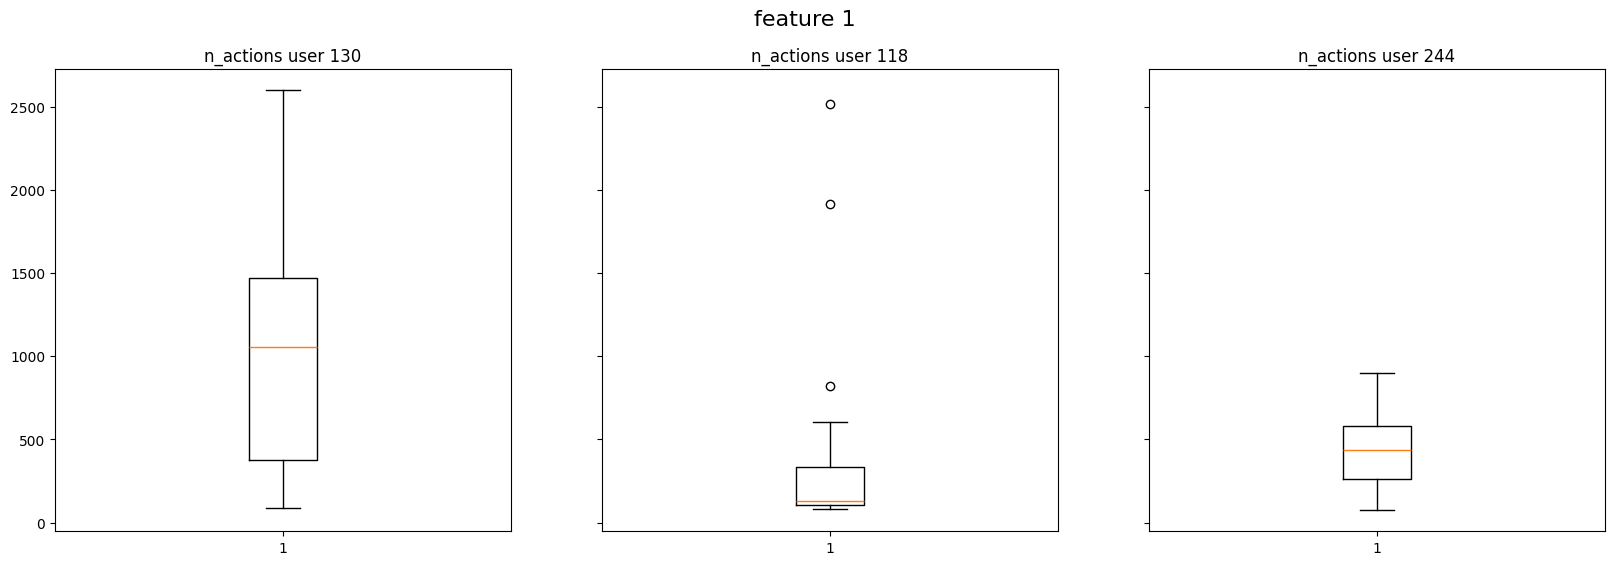

In [30]:

# ======================================
# 4-b) Sélection de features pertinentes
# ======================================

# Code du premier utilisateur
utilisateur_code0 = train_feats.iloc[0]["util"]
utilisateur_code1 = train_feats.iloc[1]["util"]
utilisateur_code2 = train_feats.iloc[2]["util"]

# Récupérer les 3 premières features
features = train_feats.columns[:3]

# Filtrer toutes les lignes pour cet utilisateur
df_util0 = train_feats[train_feats["util"] == utilisateur_code0]
df_util1 = train_feats[train_feats["util"] == utilisateur_code1]
df_util2 = train_feats[train_feats["util"] == utilisateur_code2]

# Créer la figure
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(20,6))

# Tracer les boîtes à moustaches pour chaque feature
ax1.boxplot(df_util0[features[0]].values)
ax1.set_title(features[0] + " user " + str(utilisateur_code0))

ax2.boxplot(df_util1[features[0]].values)
ax2.set_title(features[0] + " user " + str(utilisateur_code1))

ax3.boxplot(df_util2[features[0]].values)
ax3.set_title(features[0] + " user " + str(utilisateur_code2))

plt.suptitle("feature 1", fontsize=16)
plt.show()

